In [1]:
from datetime import date
from nsepy import get_history
from nsepy.derivatives import get_expiry_date
import pandas as pd
import csv
import sys
import os
import subprocess
import matplotlib.pyplot as plt 
import matplotlib
from tqdm.notebook import tqdm, trange
import time

# Prepare a list of nifty50 symbols
### Later change it to the list of symbols for study/research

In [2]:
niftylist="ind_nifty50list.csv"
nif50=[]
with open(niftylist,"r") as rf:
    r=csv.reader(rf)
    linecount=0
    for row in r:
        if linecount:
            nif50.append(row[2])
        linecount+=1
more = ["TATACHEM"]
nif50.extend(more)

In [3]:
import csv
import datetime
import requests
import urllib
import json
import yfinance as yf
import pandas as pd
from collections import defaultdict

class nse_data(object):
    def __init__(self, symbol, chart_range = '1d', chart_interval = '1m'):
        self.symbol = symbol
        self.range = chart_range
        self.interval = chart_interval
        self.data = 0

    def get_data(self):
        self.data=yf.download(self.symbol, period=self.range, interval=self.interval)
        return self.data


In [4]:
'''stock_price = get_history(symbol="MARUTI",
                   start=date(2017,1,1),
                   end=date(2017,1,25))
                         #futures=True,
                            #expiry_date=max(get_expiry_date(year=2017,month=1)))
stock_price.head(5)'''

'stock_price = get_history(symbol="MARUTI",\n                   start=date(2017,1,1),\n                   end=date(2017,1,25))\n                         #futures=True,\n                            #expiry_date=max(get_expiry_date(year=2017,month=1)))\nstock_price.head(5)'

## Collect Data

- Get monthly data on the stock and stock future for current expiry
- Get next month's data on stock future to identify OI for roll-over
- Concatenate collected data to one dataframe

In [5]:
year=2021
month=11
eval_pass = []
print("Expiry date: ", max(get_expiry_date(year,month)))
for sym in tqdm(nif50):
    stock_fut_cur = get_history(symbol=sym,
                            start=date(year,month,1),
                            #end=max(get_expiry_date(year=year,month=month)),
                            end=datetime.date(2021,11,25),
                            futures=True,
                            #expiry_date=max(get_expiry_date(year=year,month=month)))
                            expiry_date=datetime.date(2021,11,25))
    '''
    if month==12:
        n_year=year+1
        n_month=1
    else:
        n_year=year
        n_month=month+1
    stock_fut_nxt = get_history(symbol=sym,
                            start=date(year,month,1),
                            end=max(get_expiry_date(year=year,month=month)),
                            futures=True,
                            expiry_date=max(get_expiry_date(year=n_year,month=n_month)))'''
    stock_price = get_history(symbol=sym,
                   start=date(year,month,1),
                   end=max(get_expiry_date(year=year,month=month)))

    if not stock_fut_cur.empty:
        #stock_fut_cur['next_oi']=stock_fut_nxt['Open Interest']
        stock_fut_cur['%delivery'] = stock_price['%Deliverble']
        stock_fut_cur['Underlying'] = stock_price['Close']

        stock_fut_cur['coc'] = stock_fut_cur['Close'] - stock_fut_cur['Underlying']
        #stock_fut_cur = stock_fut_cur[:-1]
        eval_pass.append(stock_fut_cur)

Expiry date:  2021-11-30


  0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
# d = Pandas Dataframe, 
# ys = [ [cols in the same y], [cols in the same y], [cols in the same y], .. ] 
def chart(d,ys):

    from itertools import cycle
    fig, ax = plt.subplots(figsize=(17,7))

    axes = [ax]
    for y in ys[1:]:
        # Twin the x-axis twice to make independent y-axes.
        axes.append(ax.twinx())

    extra_ys =  len(axes[2:])

    # Make some space on the right side for the extra y-axes.
    if extra_ys>0:
        temp = 0.85
        if extra_ys<=2:
            temp = 0.75
        elif extra_ys<=4:
            temp = 0.6
        if extra_ys>5:
            print ('you are being ridiculous')
        fig.subplots_adjust(right=temp)
        right_additive = (0.98-temp)/float(extra_ys)
    # Move the last y-axis spine over to the right by x% of the width of the axes
    i = 1
    for ax in axes[2:]:
        ax.spines['right'].set_position(('axes', 1.+right_additive*i))
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        ax.yaxis.set_major_formatter(matplotlib.ticker.OldScalarFormatter())
        i +=1.
    # To make the border of the right-most axis visible, we need to turn the frame
    # on. This hides the other plots, however, so we need to turn its fill off.

    cols = []
    lines = []
    line_styles = cycle(['-','-','-', '--', '-.', ':', '.', ',', 'o', 'v', '^', '<', '>',
               '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_'])
    colors = cycle(matplotlib.rcParams['axes.prop_cycle'])
    for ax,y in zip(axes,ys):
        #ls=line_styles.next()
        ls=next(line_styles)
        if len(y)==1:
            col = y[0]
            cols.append(col)
            #color = colors.next()
            color=next(colors)['color']
            lines.append(ax.plot(d[col],linestyle =ls,label = col,color=color))
            ax.set_ylabel(col,color=color)
            #ax.tick_params(axis='y', colors=color)
            ax.spines['right'].set_color(color)
        else:
            for col in y:
                #color = colors.next()
                color=next(colors)['color']
                lines.append(ax.plot(d[col],linestyle =ls,label = col,color=color))
                cols.append(col)
            ax.set_ylabel(', '.join(y))
            #ax.tick_params(axis='y')
    axes[0].set_xlabel(d.index.name)
    lns = lines[0]
    for l in lines[1:]:
        lns +=l
    labs = [l.get_label() for l in lns]
    axes[0].legend(lns, labs, loc=0)

    plt.show()

In [7]:
def chart_v2(df):
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()
    df['Open Interest'].plot(kind='bar', color='y', ax=ax1)
    df['coc'].plot(kind='line', color='b', ax=ax2)
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    plt.show()
    return

## Plot the data and observe

- Delta coc from start of month up until expiry is important. It decides whether it's worth squaring off. Assign a threshold.
- If delta coc < threshold : plot the graph (remove this criterion when testing in Feb 21 expiry)

### Initial thoughts
- In the graph, if there is a spike in delivery volume at the beginning of the month, it is more likely to be dumped on expiry day
- CoC has been generally high throughout the month
- OI is high in the beginning of the month

In [8]:
his_oi = []
his_coc = []
for item in tqdm(eval_pass):
    try:
        #checklist=["BAJAJ-AUTO","DIVISLAB","DRREDDY","HCLTECH","HDFCBANK","HINDUNILVR","IOC","KOTAKBANK","SBIN","WIPRO","TCS"]
        checklist = nif50
        item.drop(item.tail(1).index,inplace=True)
        if item.iloc[0]['Symbol'] in checklist:
            per_delta_coc = (item.iloc[0]['coc']-item.iloc[-1]['coc'])/item.iloc[0]['coc']
            per_delta_oi = (item.iloc[0]['Open Interest']/item.iloc[-1]['Open Interest'])
            his_oi.append(per_delta_oi)
            his_coc.append(per_delta_coc)
            print("Symbol: ",item.iloc[0]['Symbol'])
            print("Expiry: ",item.iloc[0]['Expiry'])
            print("%Change in CoC: ",per_delta_coc)
            print("Factor in current OI: ", per_delta_oi)
            #chart(item,[['%delivery'],['Open Interest'],['next_oi'],['coc']])
            
            #chart(item,[['Open Interest'],['coc']])
            
            #chart_v2(item)

            #filename = "live_data_collection/"+item.iloc[0]['Symbol'] + str(item.iloc[0]['Expiry']) + ".csv"
            #item.to_csv(filename, mode='a', header=True)
            #data = nse_data(item.iloc[0]['Symbol']+".NS").get_data()
            #data.to_csv(filename, mode='a', header=True)
    except Exception as e:
        print(e)
        pass    

  0%|          | 0/51 [00:00<?, ?it/s]

Symbol:  ADANIPORTS
Expiry:  2021-11-25
%Change in CoC:  1.2637362637362697
Factor in current OI:  5.282120769925648
Symbol:  ASIANPAINT
Expiry:  2021-11-25
%Change in CoC:  1.3632286995515976
Factor in current OI:  2.464047442550037
Symbol:  AXISBANK
Expiry:  2021-11-25
%Change in CoC:  0.9175257731958814
Factor in current OI:  1.8691071253552876
Symbol:  BAJAJ-AUTO
Expiry:  2021-11-25
%Change in CoC:  0.7676767676767691
Factor in current OI:  1.4579182907463548
Symbol:  BAJFINANCE
Expiry:  2021-11-25
%Change in CoC:  1.2204836415362696
Factor in current OI:  2.062054648487909
Symbol:  BAJAJFINSV
Expiry:  2021-11-25
%Change in CoC:  1.2382838283828286
Factor in current OI:  2.2207515953675254
Symbol:  BPCL
Expiry:  2021-11-25
%Change in CoC:  1.2272727272727284
Factor in current OI:  2.285163007318696
Symbol:  BHARTIARTL
Expiry:  2021-11-25
%Change in CoC:  1.560975609756099
Factor in current OI:  2.702139417383753
Symbol:  BRITANNIA
Expiry:  2021-11-25
%Change in CoC:  1.030303030303

In [9]:
fn_oi = "live_data_collection/historic_factors_oi.csv"
with open(fn_oi, 'a') as f:
    w=csv.writer(f)
    w.writerow(his_oi)

In [10]:
fn_coc = "live_data_collection/historic_factors_coc.csv"
with open(fn_coc, 'a') as f:
    w=csv.writer(f)
    w.writerow(his_coc)

In [11]:
import numpy as np
fn_oi = "live_data_collection/historic_factors_oi.csv"
fn_coc = "live_data_collection/historic_factors_coc.csv"
csv_table_oi = np.genfromtxt(fn_oi, delimiter=",",dtype=None)
transposed_oi = csv_table_oi.T

csv_table_coc = np.genfromtxt(fn_coc, delimiter=",",dtype=None)
transposed_coc = csv_table_coc.T


<ipython-input-11-a0763523487d>:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  csv_table_oi = np.genfromtxt(fn_oi, delimiter=",",dtype=None)
<ipython-input-11-a0763523487d>:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  csv_table_coc = np.genfromtxt(fn_coc, delimiter=",",dtype=None)


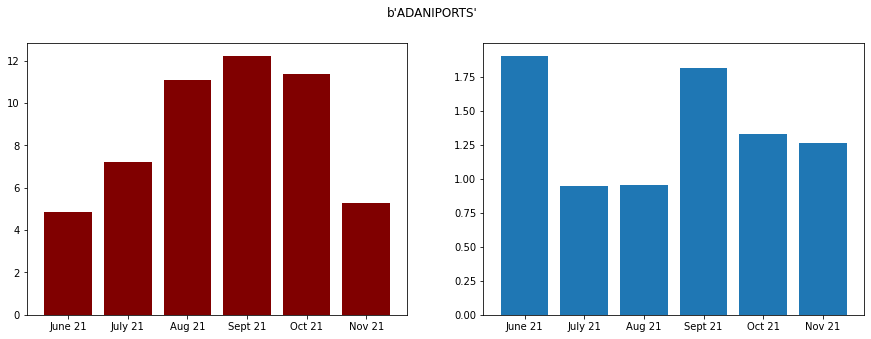

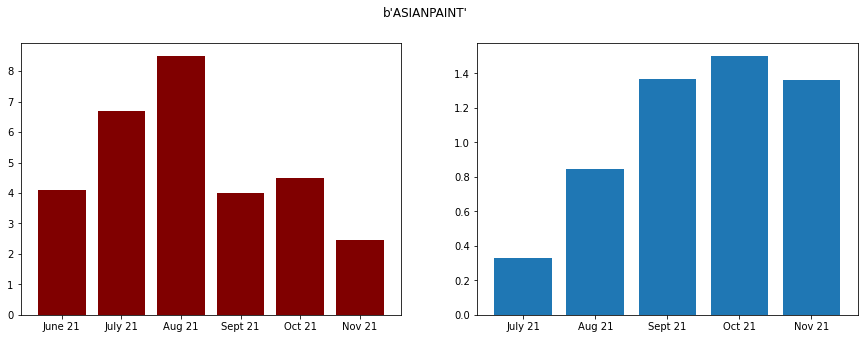

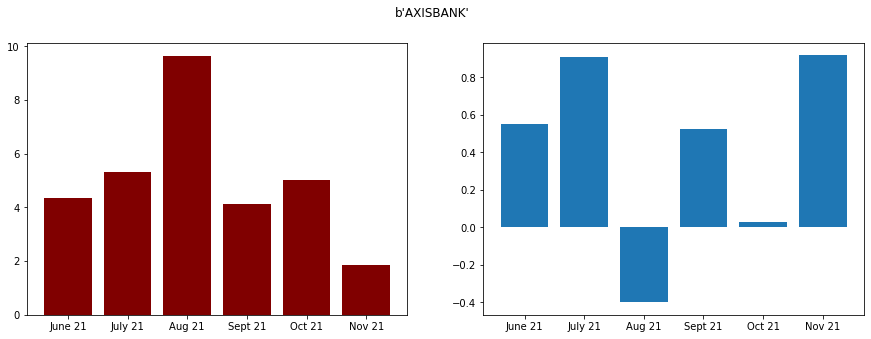

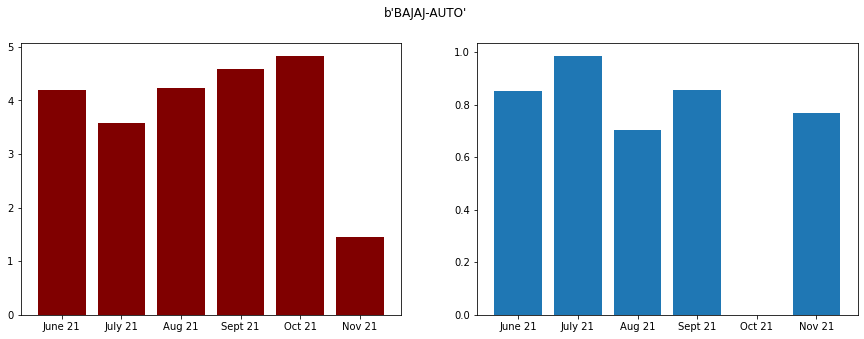

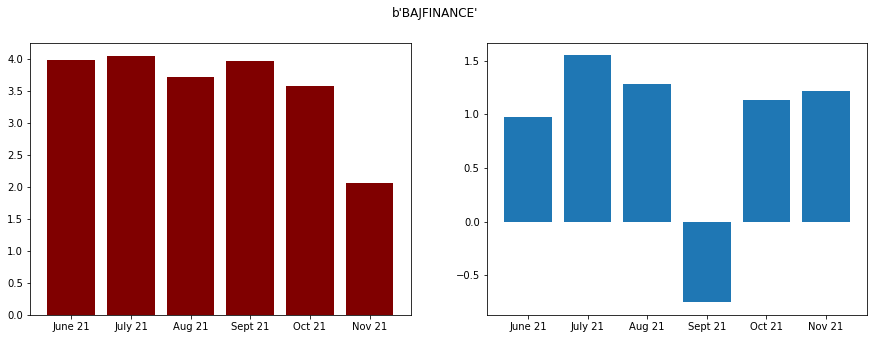

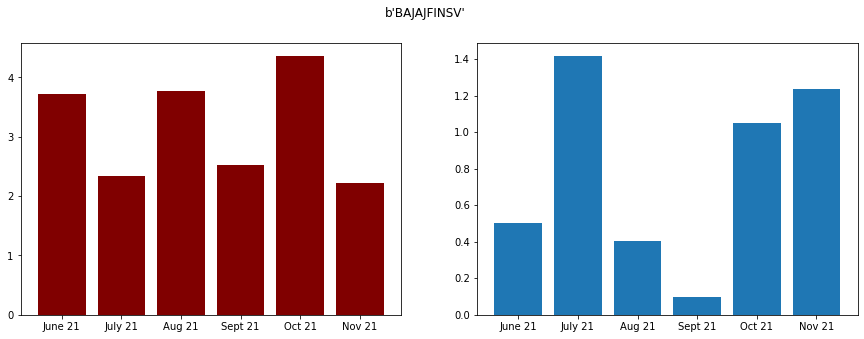

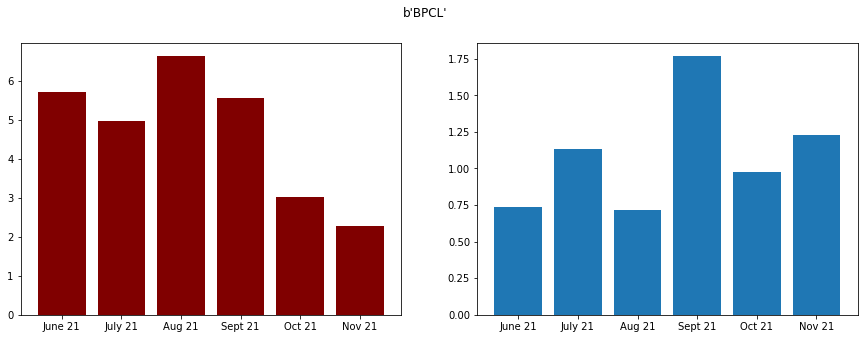

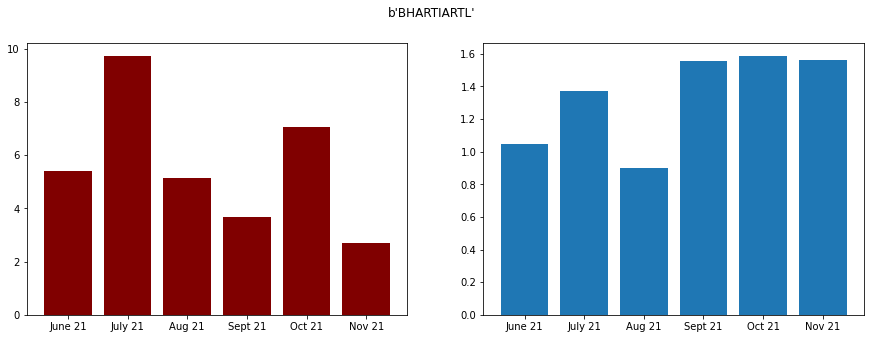

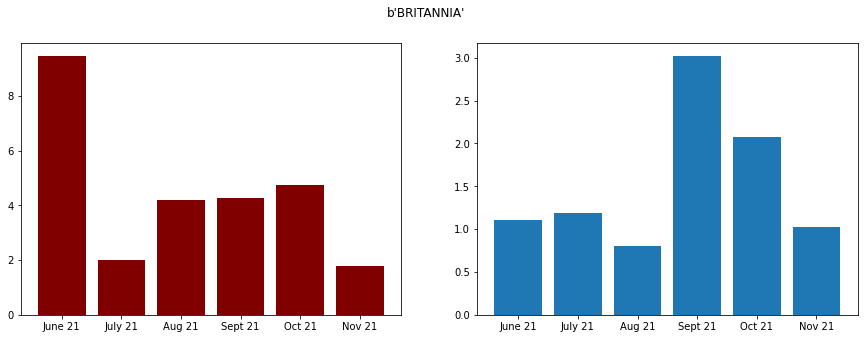

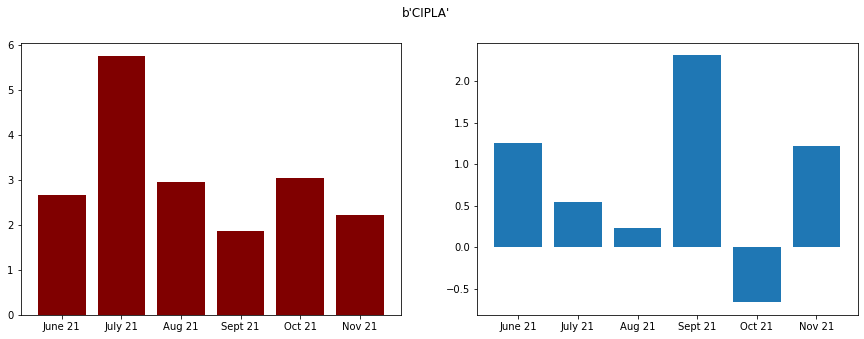

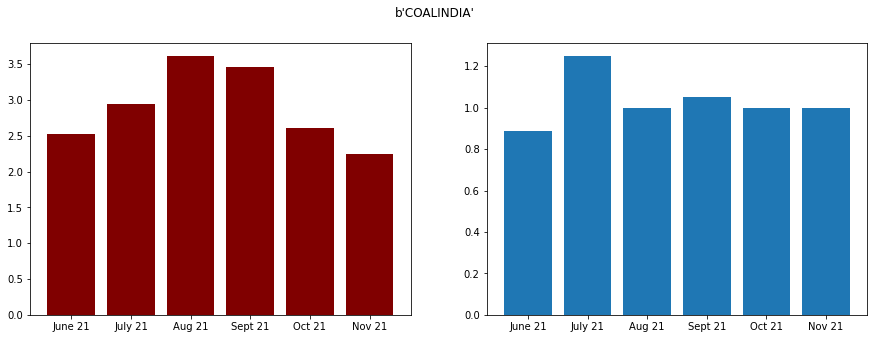

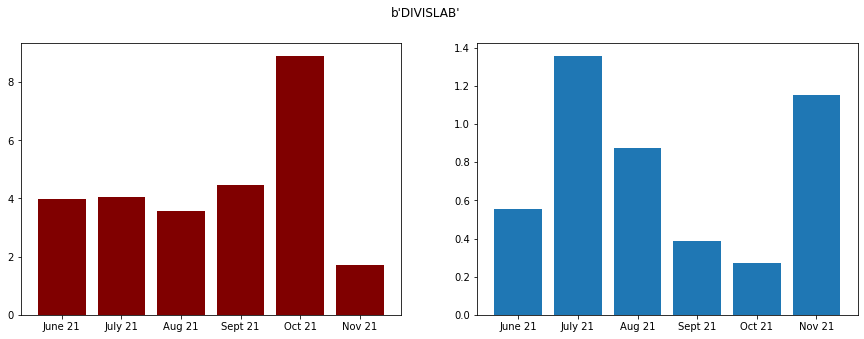

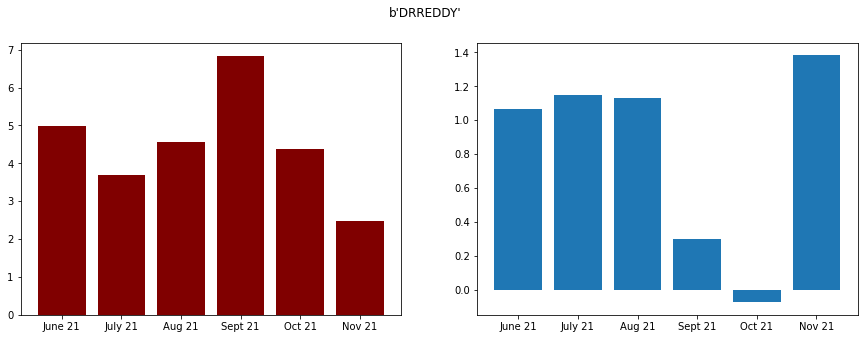

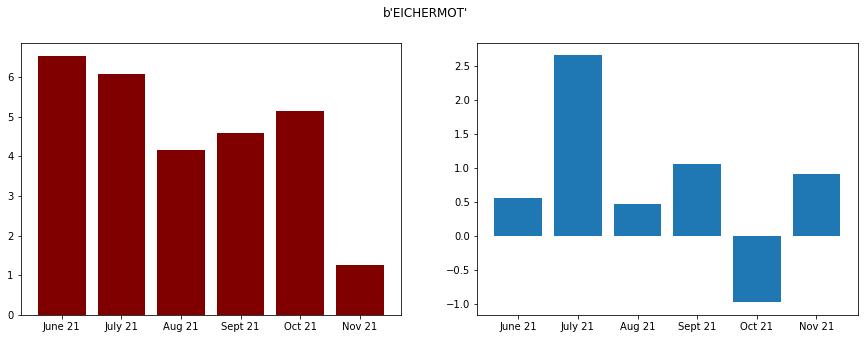

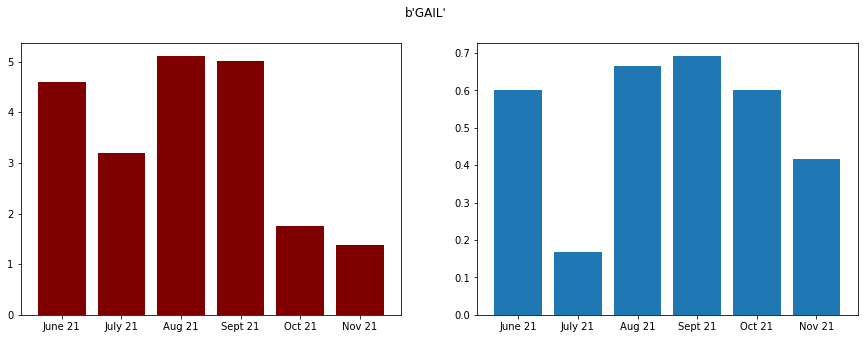

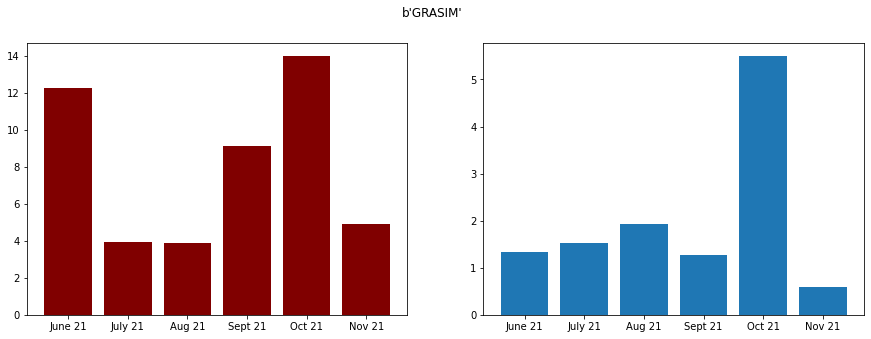

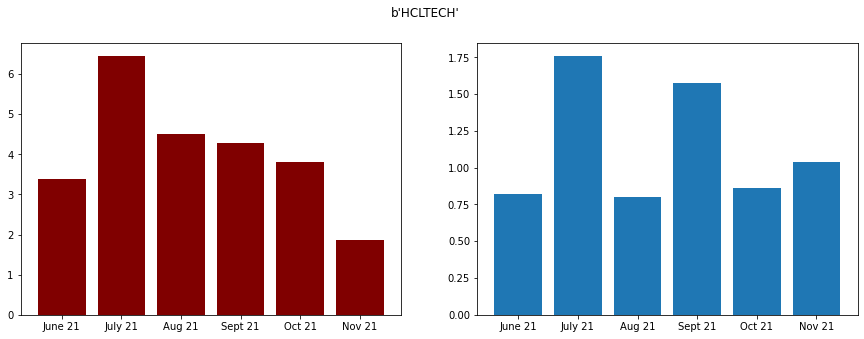

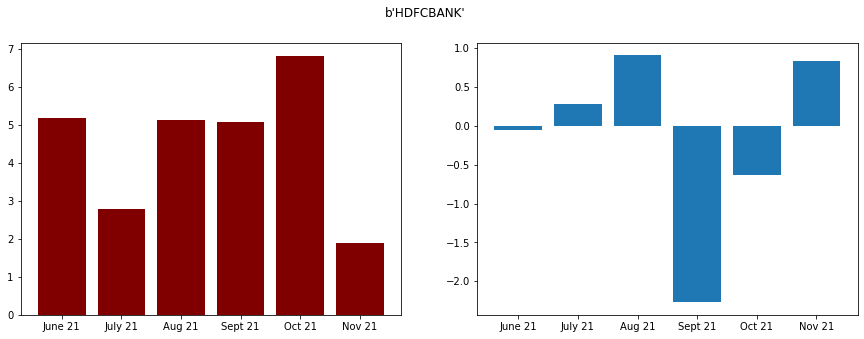

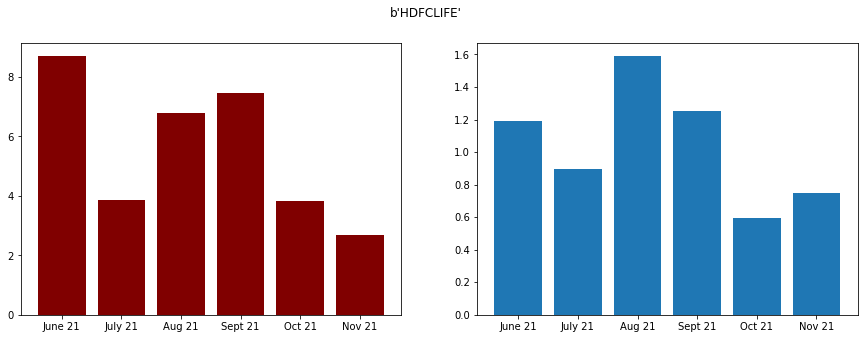

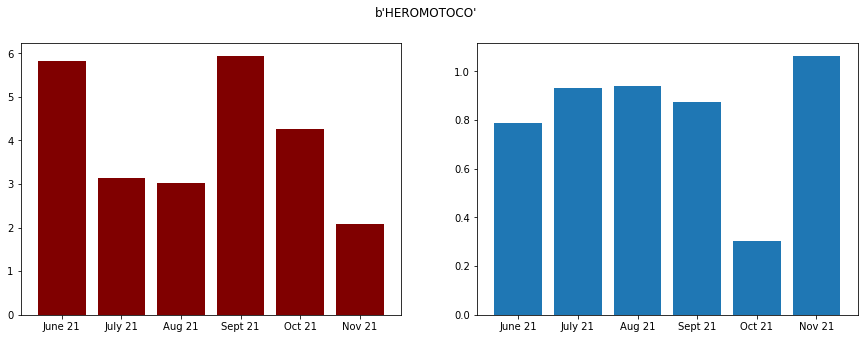

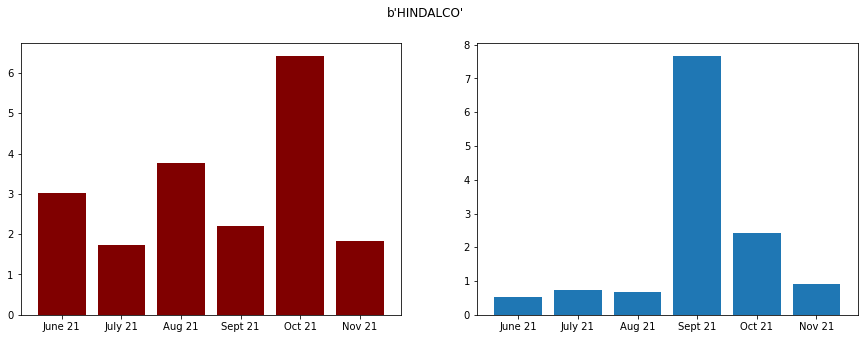

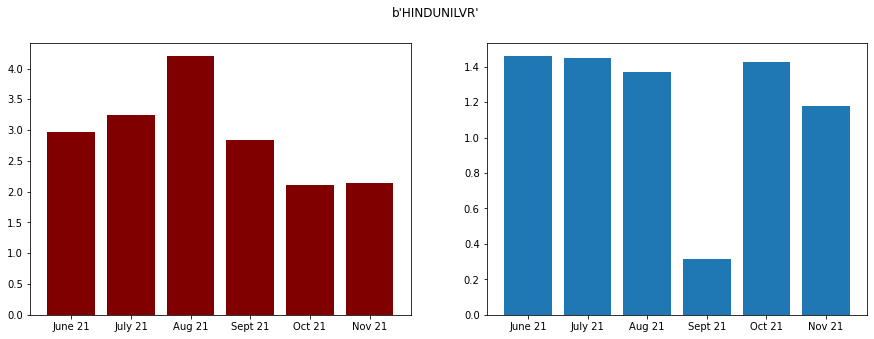

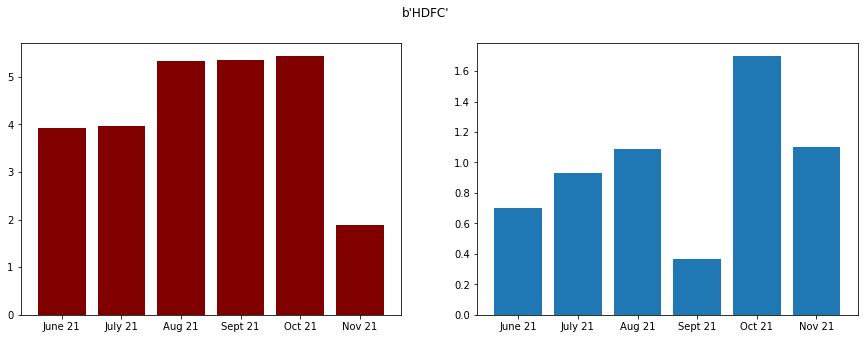

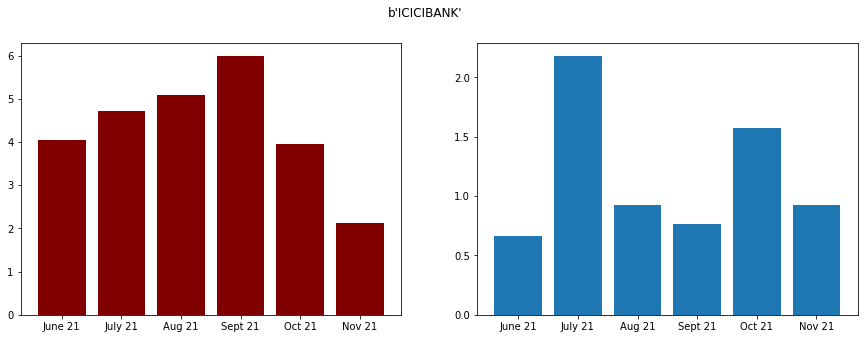

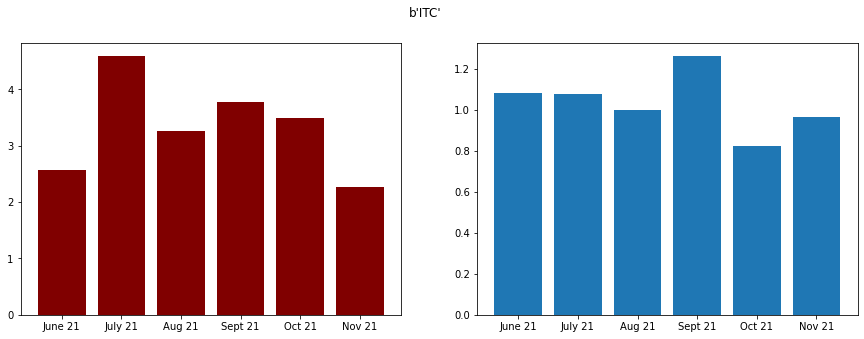

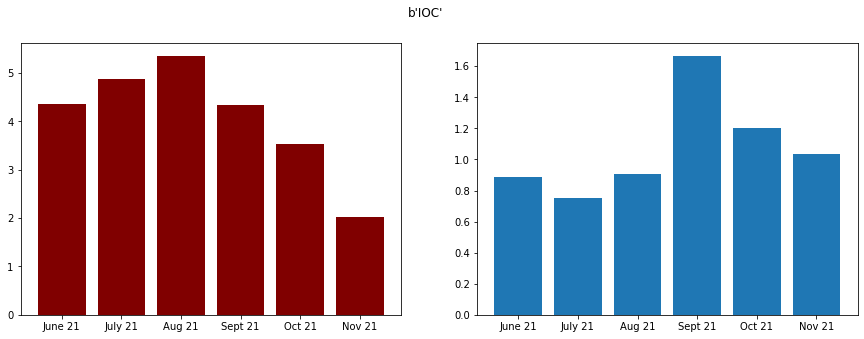

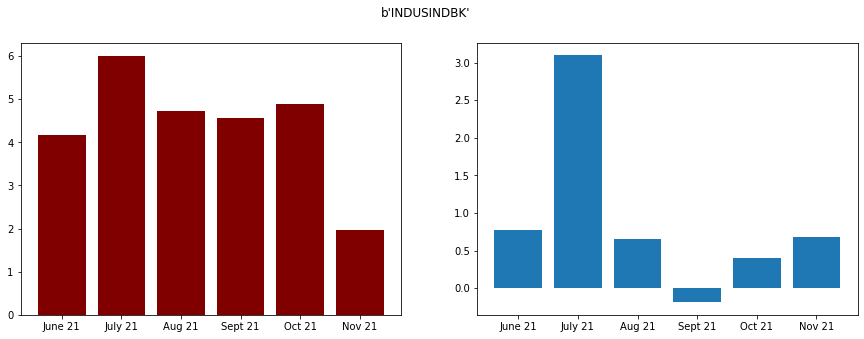

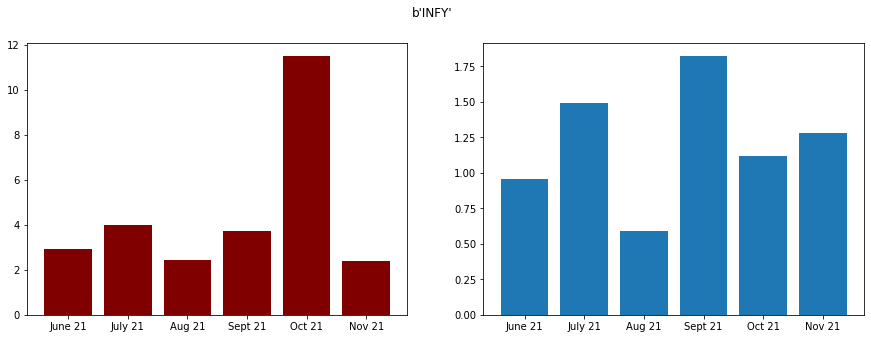

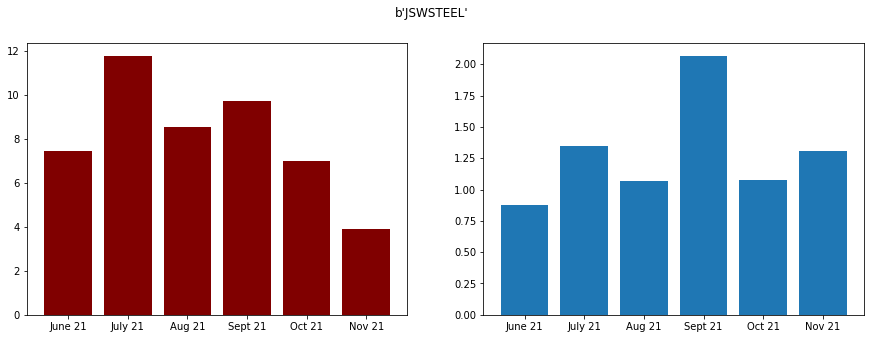

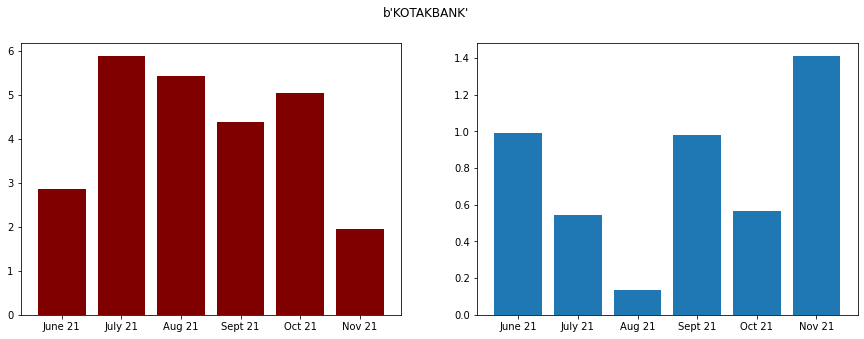

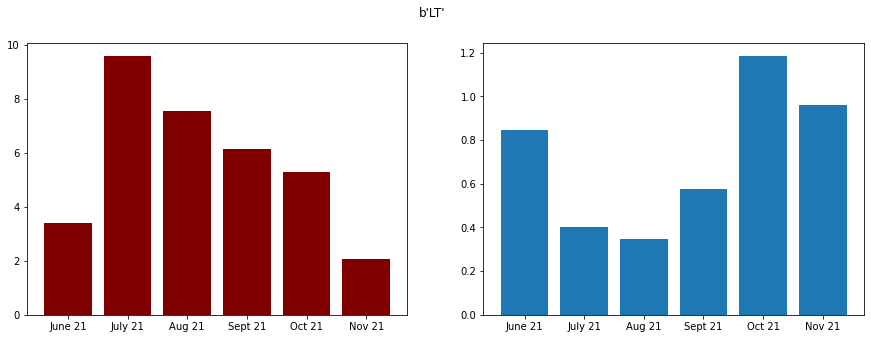

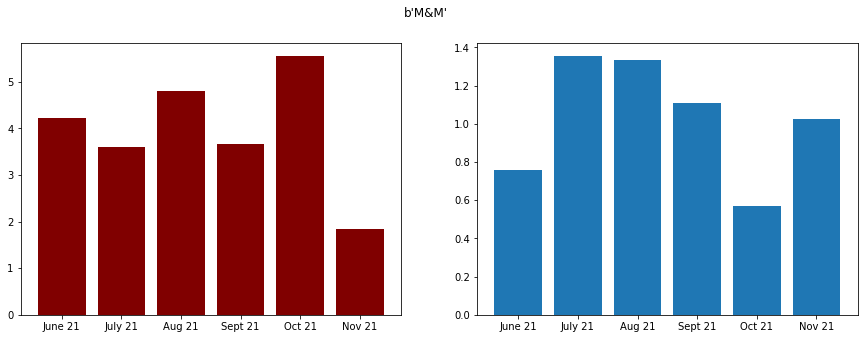

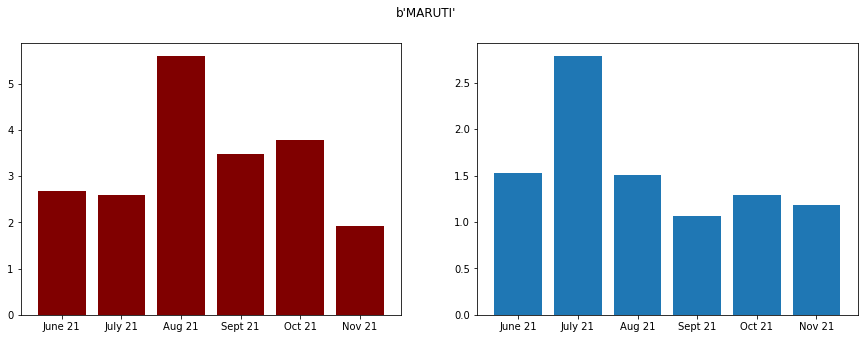

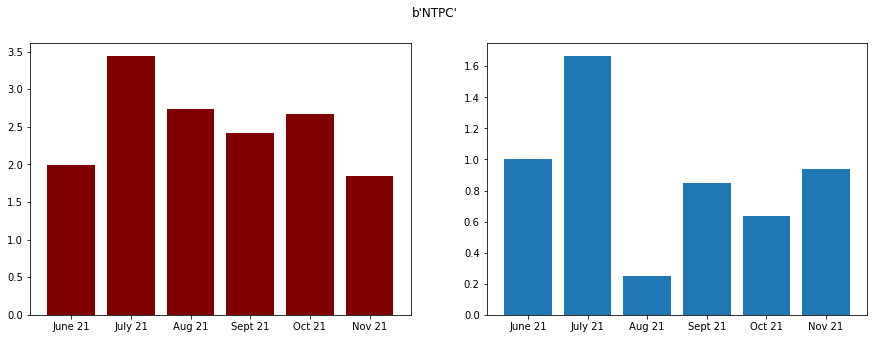

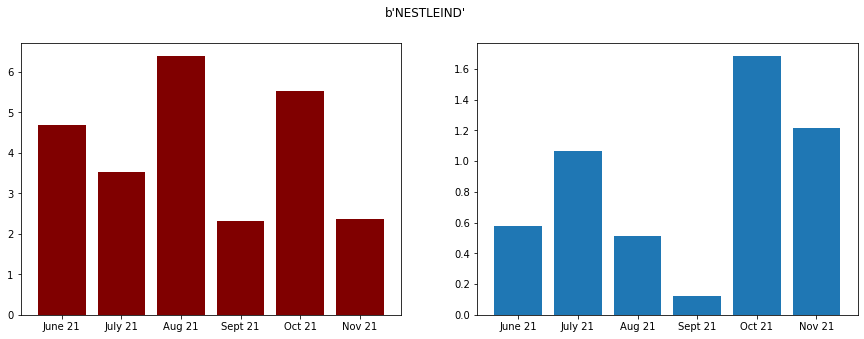

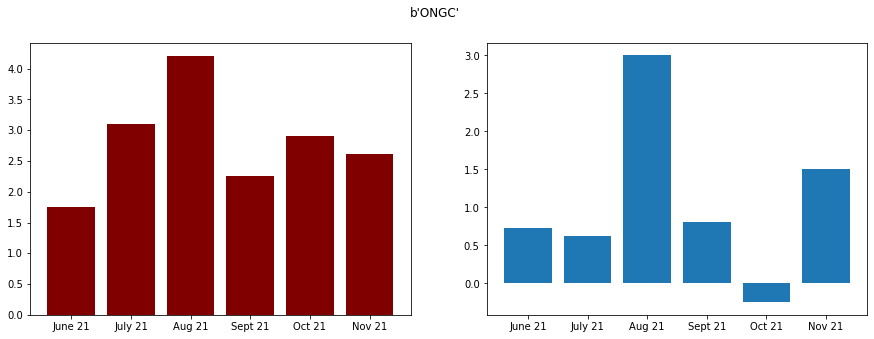

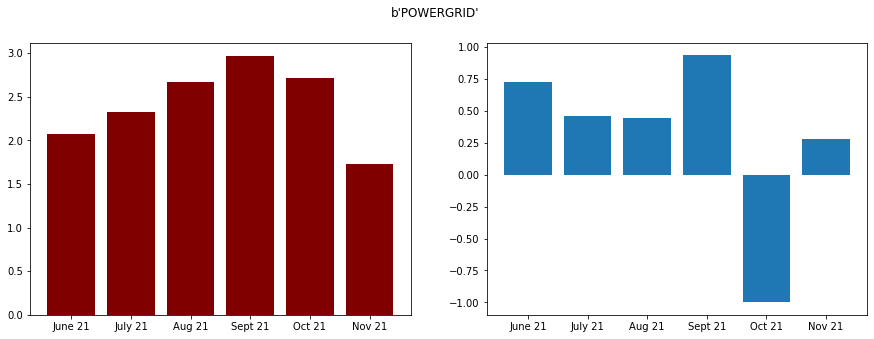

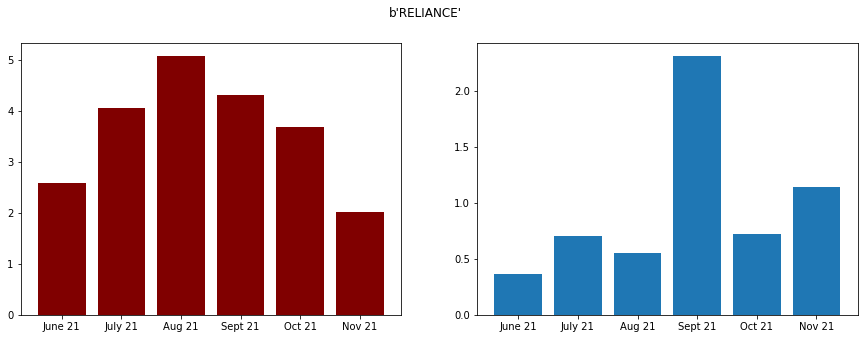

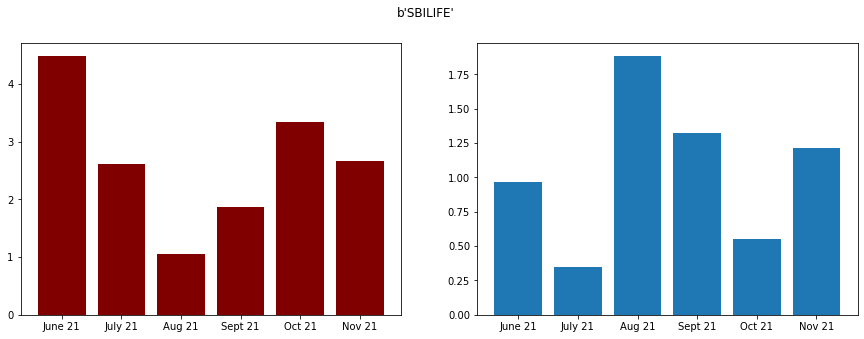

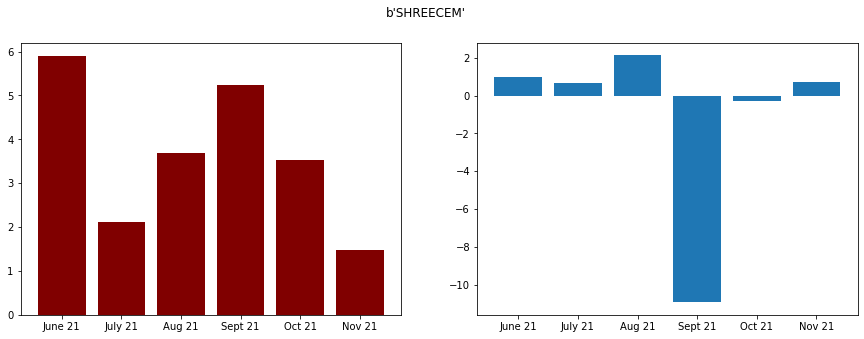

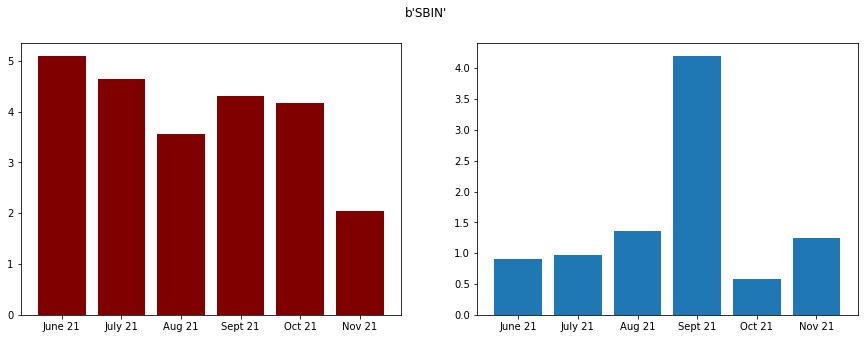

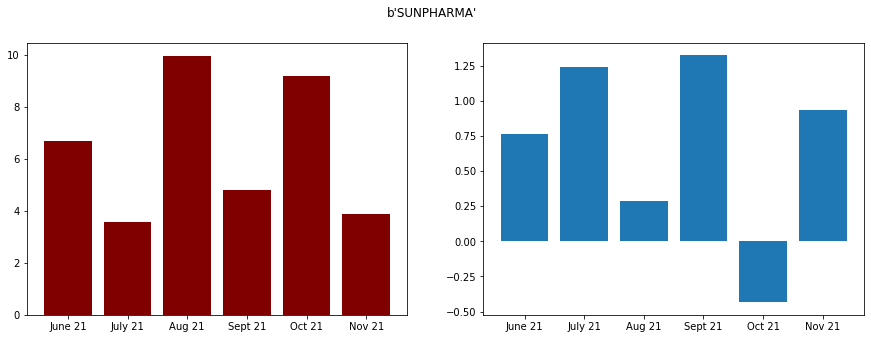

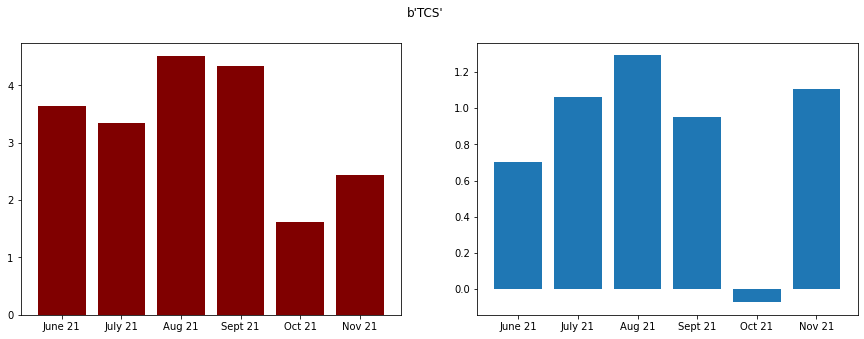

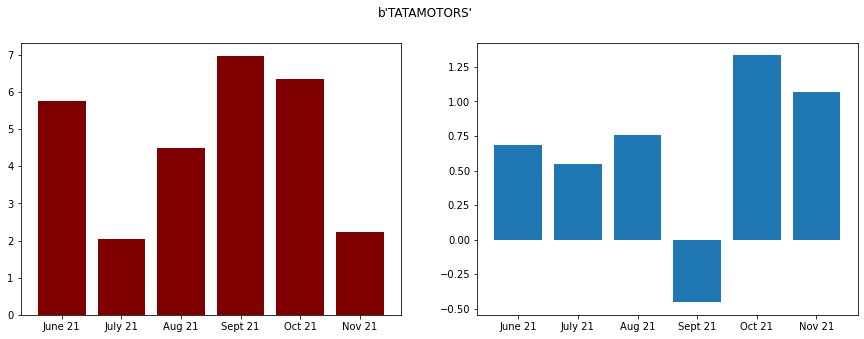

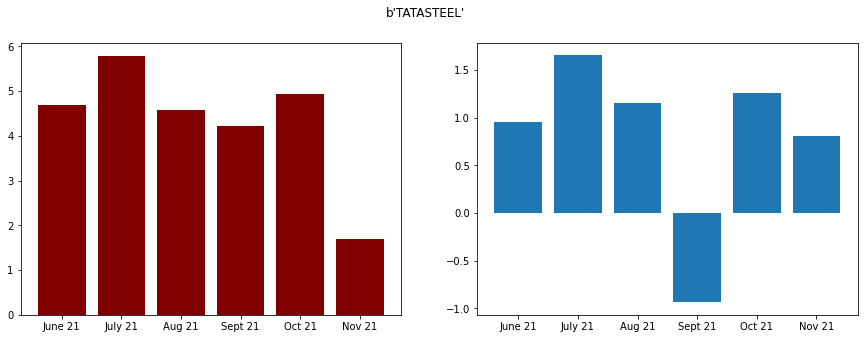

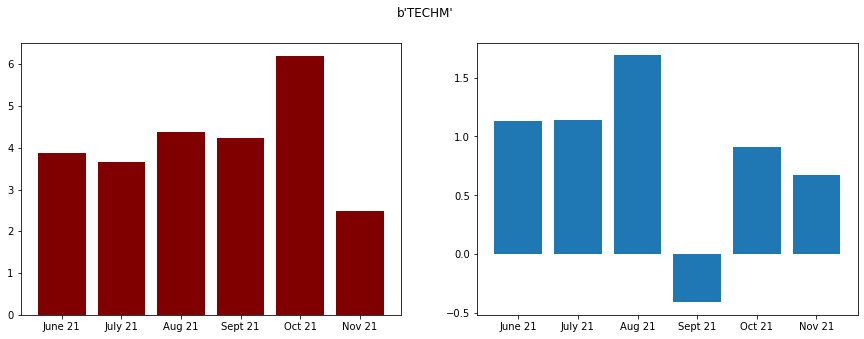

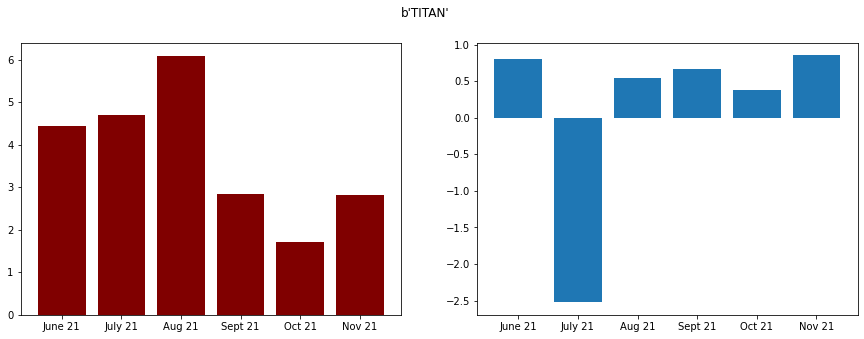

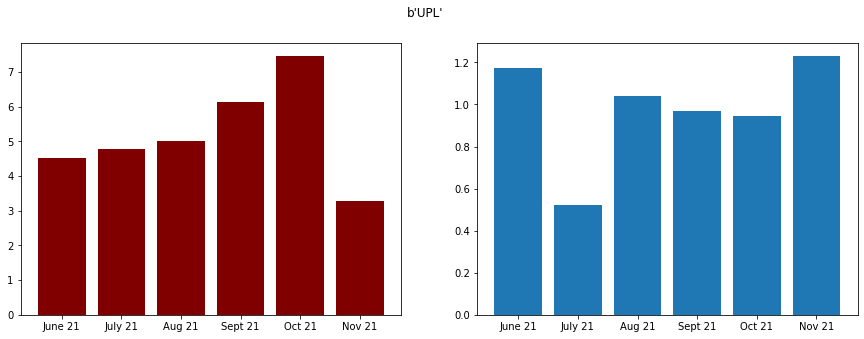

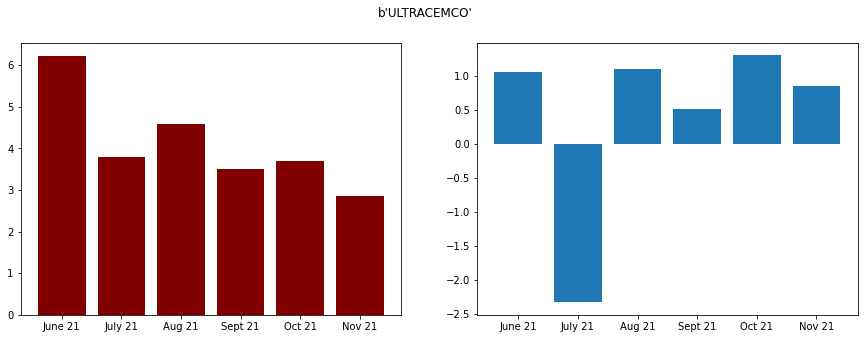

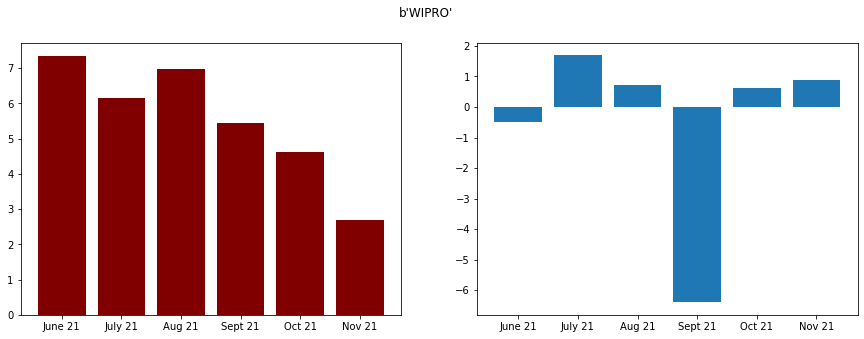

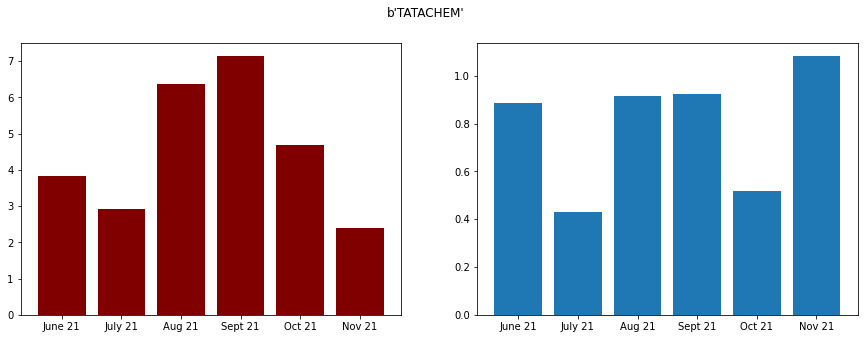

In [12]:
import matplotlib.pyplot as plt
xa = ["June 21", "July 21", "Aug 21", "Sept 21", "Oct 21", "Nov 21"]
'''
c=0
for row in transposed_oi:
    for i in row[1:len(row)]:
        xa.append(c)
        c+=1
    break
'''
count = 0
for row in transposed_oi:
    l = len(row)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(str(row[0]))

    ya_oi = [float(i) for i in row[1:l]]
    ya_coc = [float(i) for i in transposed_coc[count][1:l]]
    ax1.bar(xa, ya_oi, color="maroon")
    ax2.bar(xa, ya_coc) 
    plt.show()
    count+=1